In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from glob import glob

In [166]:
def open_cfg(file):
    with open(file, 'rt') as f:
        data = json.loads(f.read())

    for key in list(data.keys()):
        if type(data[key]) == list:
            data[key] = tuple(data[key])
    return data

def dicts_equal(dict1, dict2):
    keys1 = tuple(sorted(list(dict1.keys())))
    keys2 = tuple(sorted(list(dict2.keys())))
    if keys1 != keys2:
        return False
    for key in keys1:
        if dict1[key] != dict2[key]:
            return False
    return True

In [167]:
logs = sorted(glob('results/*.csv'))
logs = {log: pd.read_csv(log) for log in logs}
logs = {key: val for key, val in logs.items() if val.shape == (30, 84)}
logs = {key.removeprefix('results/').removesuffix('.csv'): val for key, val in logs.items()}
logs = {key: {'log': val, 'cfg': open_cfg(f'results/{key}.cfg')} for key, val in logs.items()}
print(len(logs))

46


In [168]:
def add_best_valid_quality(logs):
    for name, log in logs.items():
        history = log['log']
        valid_max_aucs = history['valid_mean_rocaucs'].max()
        log['cfg']['max_valid_mean_rocaucs'] = valid_max_aucs

add_best_valid_quality(logs)

In [169]:
cfgs = {name: log['cfg'] for name, log in logs.items()}

In [170]:
goods = dict()
no_compare_keys = ['seed', 'max_valid_mean_rocaucs', 'train_classes', 'valid_classes', 'test_classes', 'test_metrics']
while len(cfgs) > 0:
    name = list(cfgs.keys())[0]
    cfg = cfgs[name]
    noseed_cfg = {key: val for key, val in cfg.items() if key not in no_compare_keys}
    goods[name] = cfg
    goods[name]['max_valid_mean_rocaucs'] = {cfg['seed']: cfg['max_valid_mean_rocaucs']}
    goods[name]['cfg_names'] = {cfg['seed']: name}
    del cfgs[name]

    for name_2 in list(cfgs.keys()):
        cfg_2 = cfgs[name_2]
        noseed_cfg_2 = {key: val for key, val in cfg_2.items() if key not in no_compare_keys}
        if dicts_equal(noseed_cfg, noseed_cfg_2):
            goods[name]['max_valid_mean_rocaucs'][cfg_2['seed']] = cfg_2['max_valid_mean_rocaucs']
            goods[name]['cfg_names'][cfg_2['seed']] = name_2
            del cfgs[name_2]

cfgs = goods

In [171]:
for key in list(cfgs.keys()):
    cfg = cfgs[key]
    cfgs[key]['max_valid_mean_rocaucs_mean'] = np.mean([val for key, val in cfg['max_valid_mean_rocaucs'].items()])

In [172]:
cfgs = {key: val for key, val in cfgs.items()}

In [173]:
df = pd.DataFrame(cfgs).T.sort_values('max_valid_mean_rocaucs_mean', ascending=False)

In [174]:
df.iloc[0]

seed                                                                          43
cache_path                                                                 cache
data_path                      /ayb/vol1/datasets/ecg_datasets/physionet.org/...
logs_path                                                                results
models_path                                                              results
test_size                                                                    0.2
valid_size                                                                  0.25
min_class_count                                                              200
batch_size                                                                   256
num_workers                                                                   12
ecg_sr                                                                       128
window                                                                      1280
text_embedding_size         

In [176]:
df.iloc[0]['cfg_names']

{43: '7a0ff6b02309', 44: 'c99398b9f189', 42: 'd34730a0aeca'}

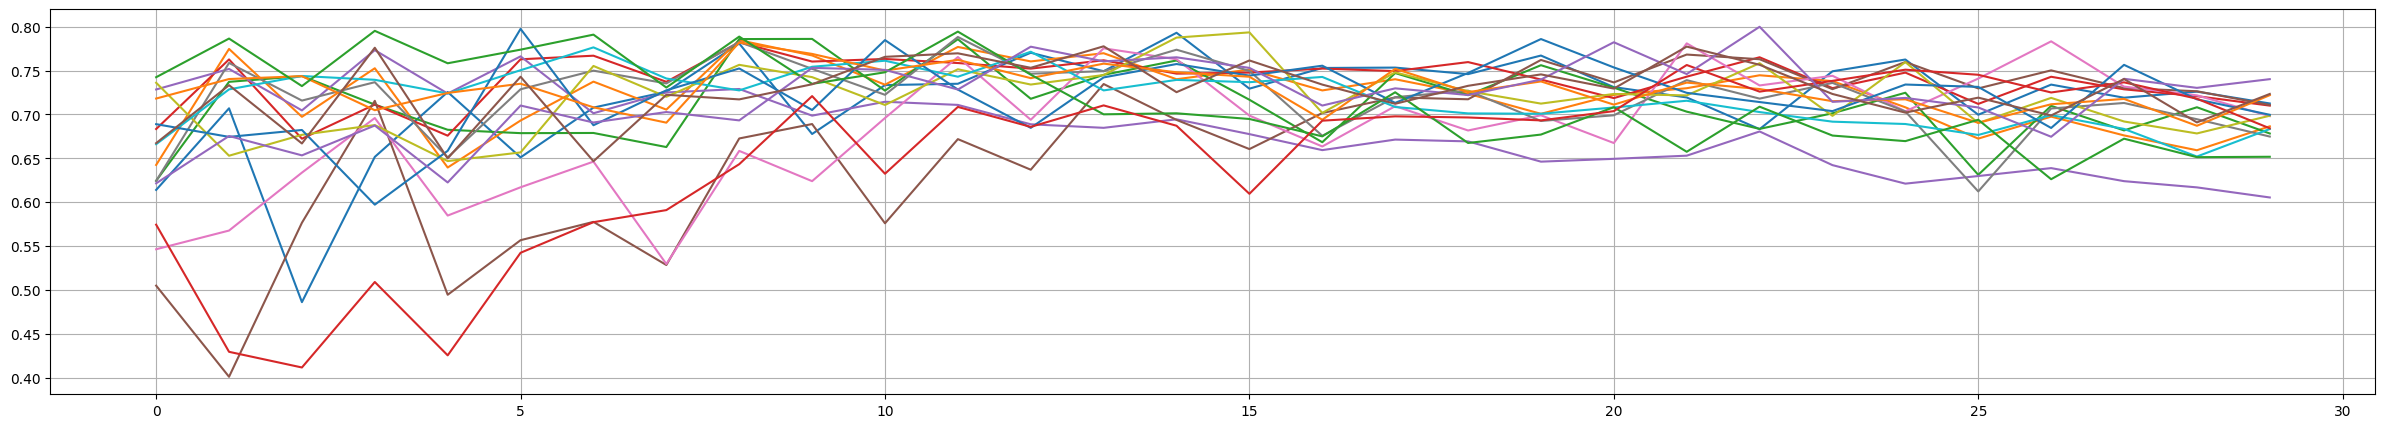

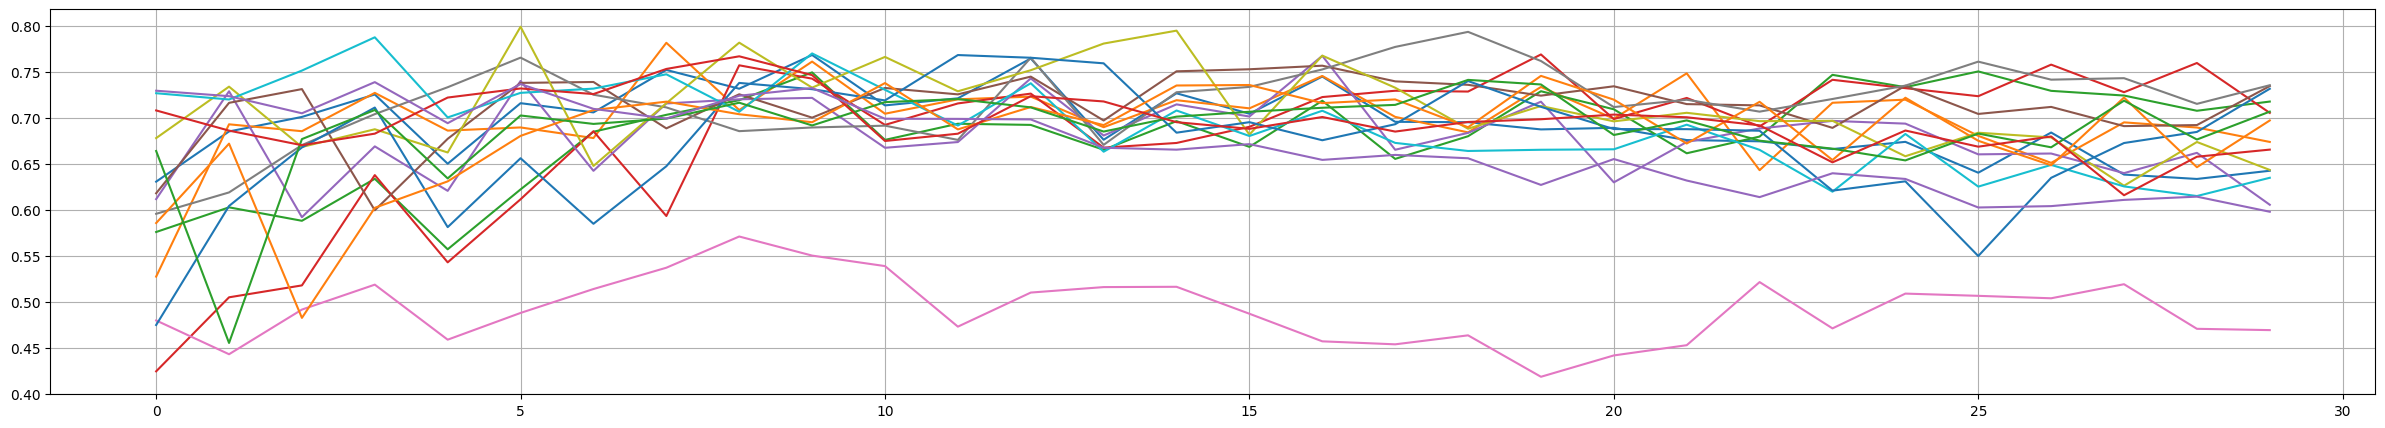

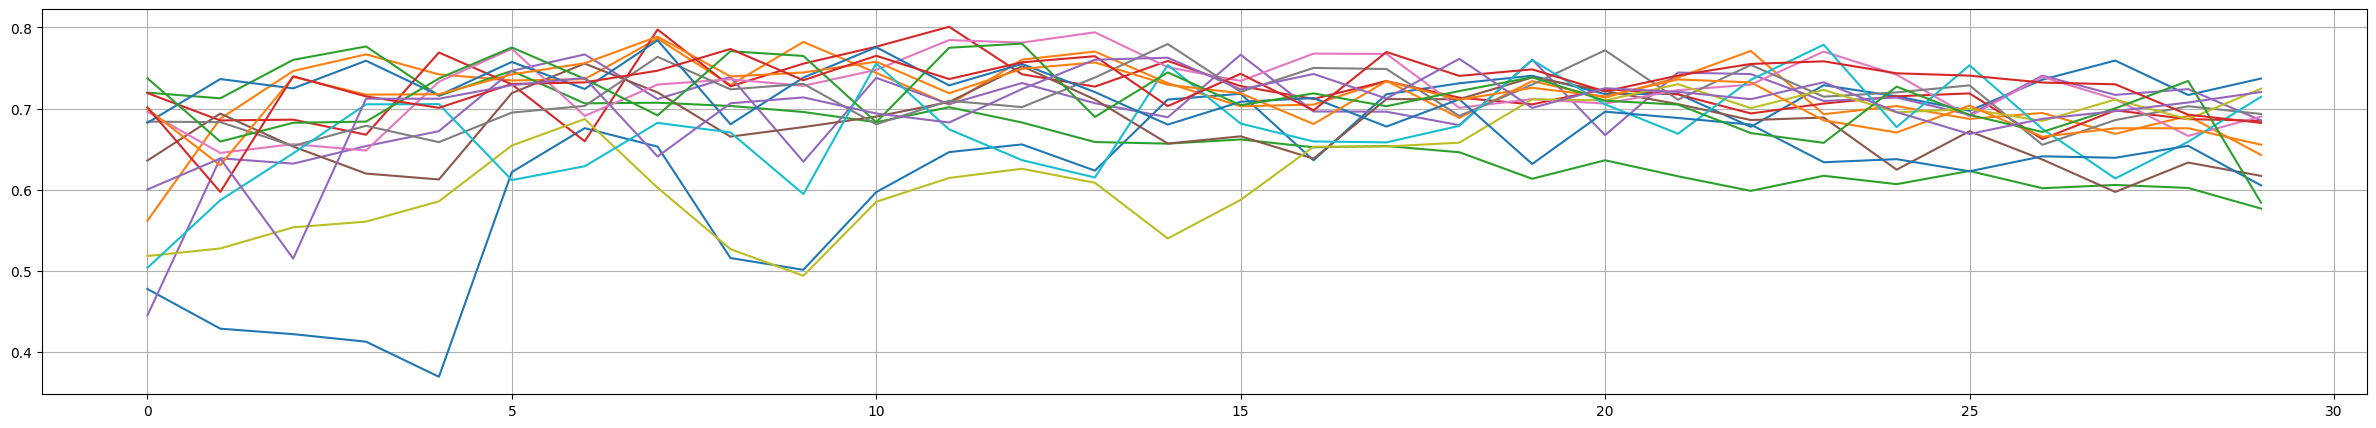

In [175]:
plt.figure(figsize=(30, 5))
for name, log in logs.items():
    if log['cfg']['seed'] == 42:
        plt.plot(log['log']['valid_mean_rocaucs'])
plt.grid()
plt.show()

plt.figure(figsize=(30, 5))
for name, log in logs.items():
    if log['cfg']['seed'] == 43:
        plt.plot(log['log']['valid_mean_rocaucs'])
plt.grid()
plt.show()

plt.figure(figsize=(30, 5))
for name, log in logs.items():
    if log['cfg']['seed'] == 44:
        plt.plot(log['log']['valid_mean_rocaucs'])
plt.grid()
plt.show()

In [53]:
log['cfg']

{'seed': 42,
 'cache_path': 'cache',
 'data_path': '/ayb/vol1/datasets/ecg_datasets/physionet.org/files/challenge-2021/1.0.3/training/ptb-xl',
 'logs_path': 'results',
 'models_path': 'results',
 'test_size': 0.2,
 'valid_size': 0.25,
 'min_class_count': 200,
 'batch_size': 256,
 'num_workers': 12,
 'ecg_sr': 128,
 'window': 1280,
 'text_embedding_size': 768,
 'projection_dim': 256,
 'dropout': 0.15,
 'pretrained': True,
 'text_encoder_model': 'emilyalsentzer/Bio_ClinicalBERT',
 'text_tokenizer': 'emilyalsentzer/Bio_ClinicalBERT',
 'temperature': 10.0,
 'head_lr': 0.001,
 'image_encoder_lr': 0.001,
 'device': 'cuda:3',
 'epochs': 30,
 'max_length': 200,
 'ecg_encoder_channels': [32, 32, 64, 64, 128, 128, 256],
 'ecg_encoder_kernels': [7, 7, 5, 5, 3, 3, 3],
 'ecg_linear_size': 256,
 'ecg_embedding_size': 512,
 'ecg_channels': 12,
 'ecg_emb': 768,
 'train_classes': ['1st degree av block',
  'abnormal QRS',
  'anterior myocardial infarction',
  'atrial fibrillation',
  'complete right bun